In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
! python --version

Python 3.10.9


In [17]:
import pandas as pd
import numpy as np
import tensorflow 
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('C:/Users/HP/dataset/creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [9]:
df.shape

(284807, 31)

In [12]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

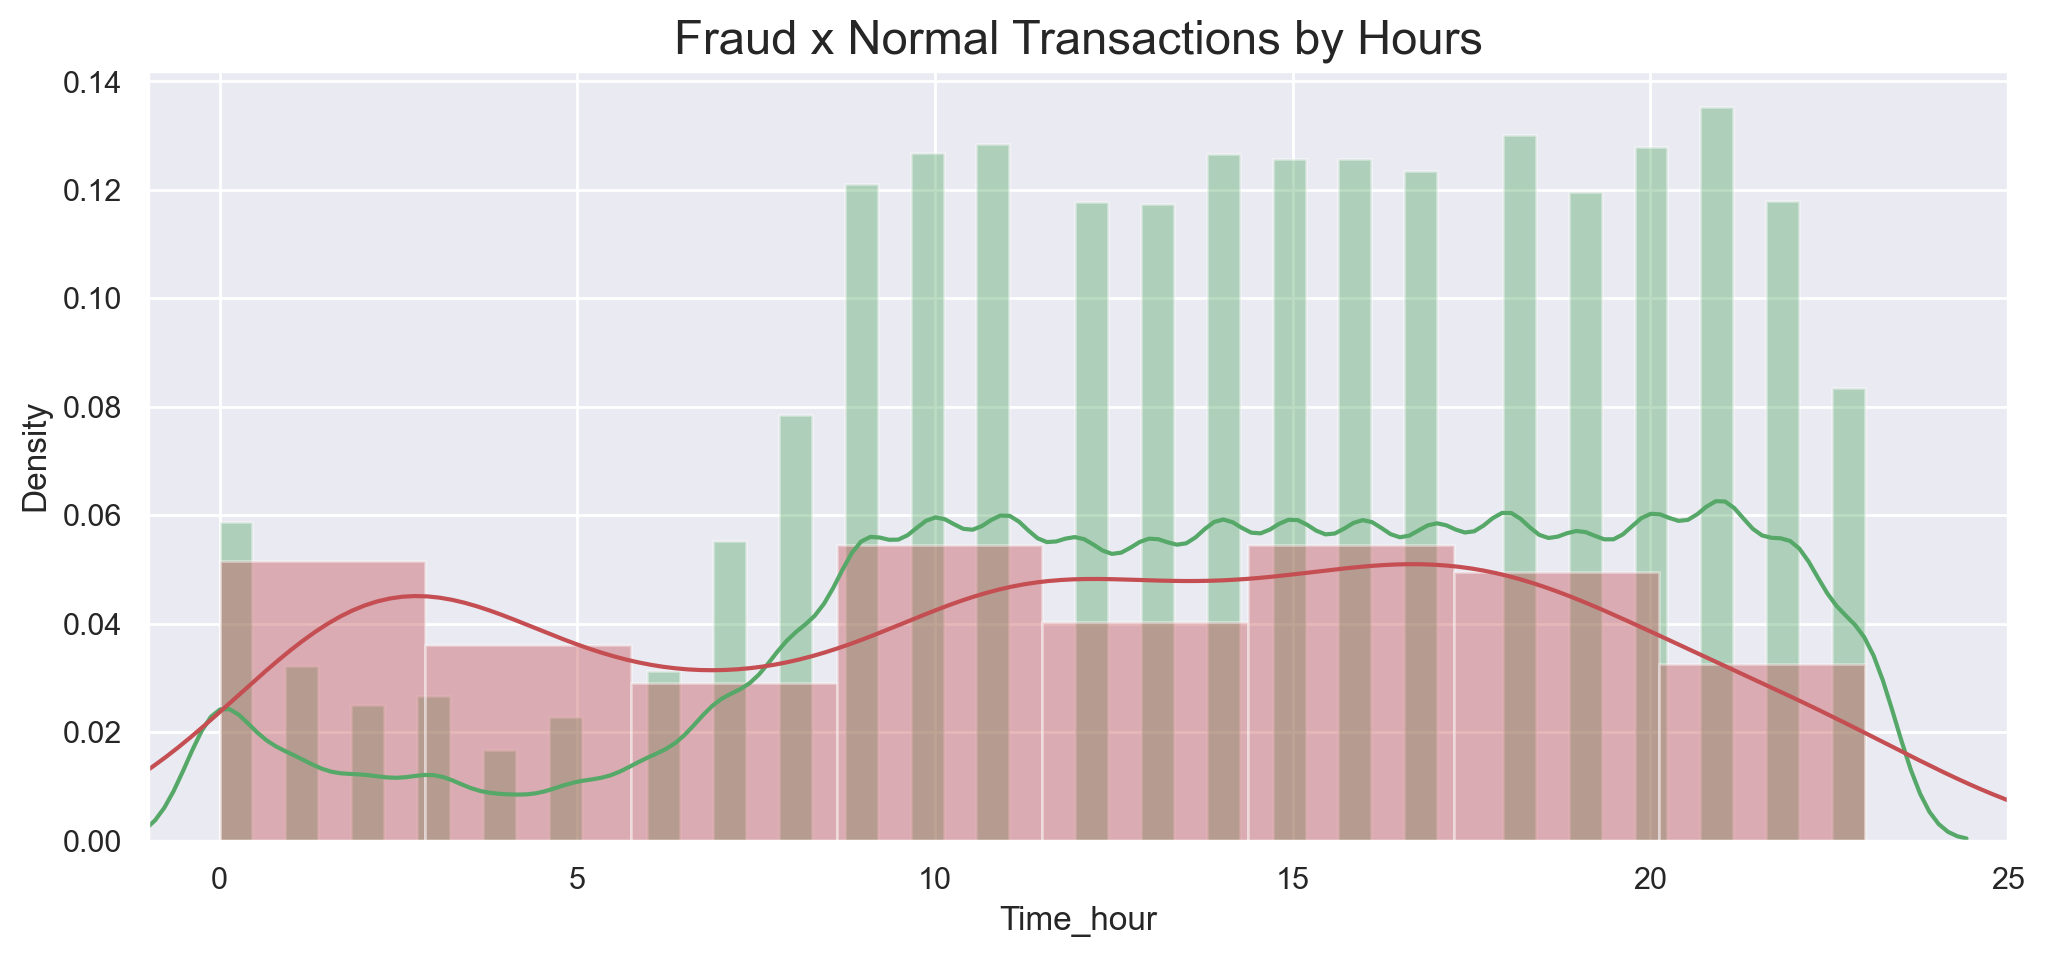

In [13]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], 
             color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], 
             color='r')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

In [14]:
df.shape

(284807, 33)

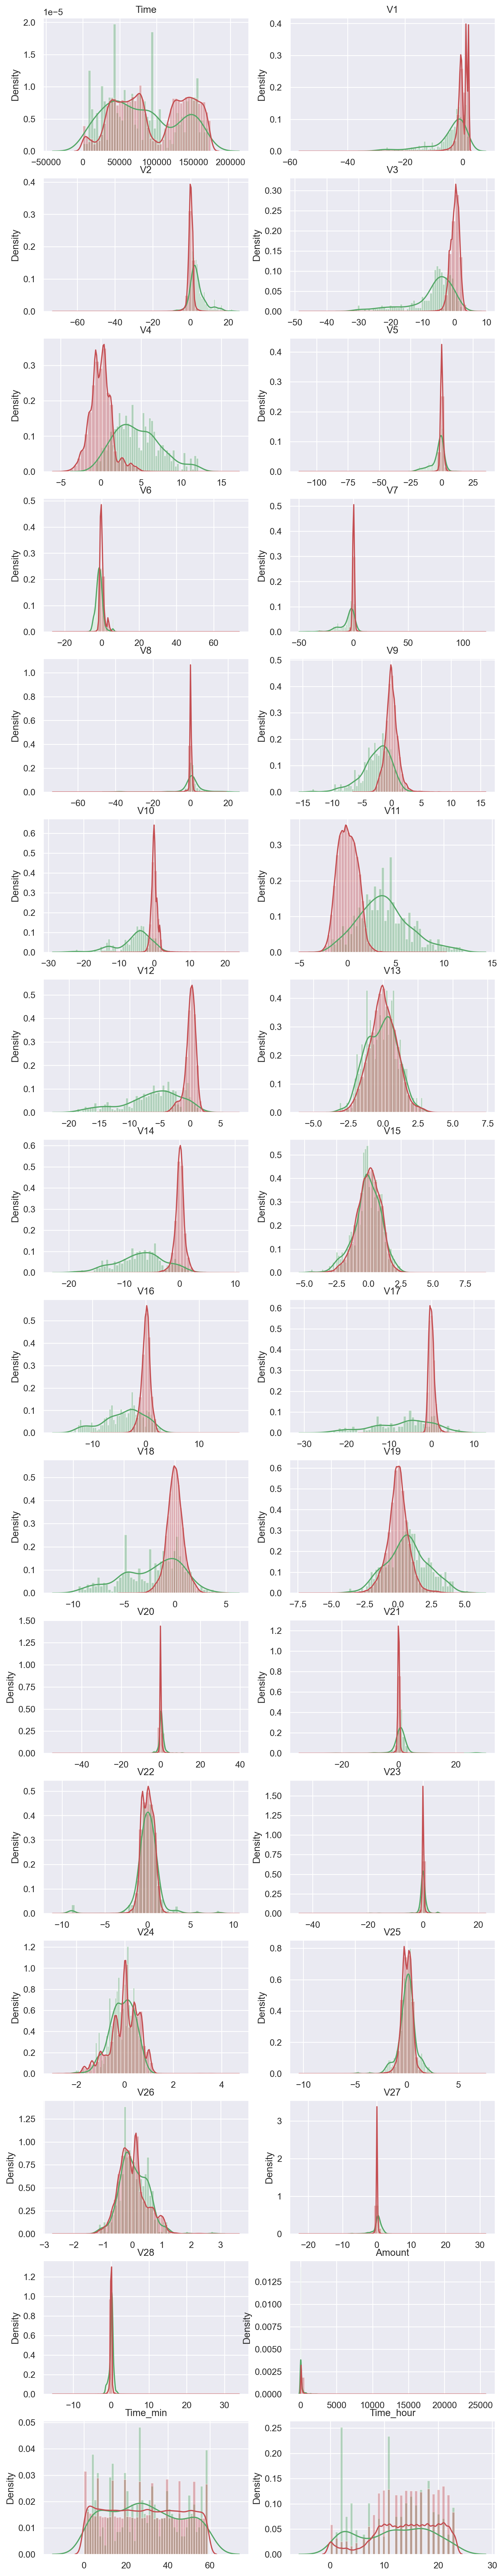

In [15]:
import matplotlib.gridspec as gridspec # to do the grid of plots #  gridspec work same as plt.subplots
columns  = df.iloc[:,df.columns  != 'Class'].columns
frauds = df.Class == 1
normals = df.Class == 0
grid = gridspec.GridSpec(17, 2)
plt.figure(figsize=(10,15*4))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
    sns.distplot(df[col][normals], bins = 50, color='r') #Will receive the "ocean" color
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

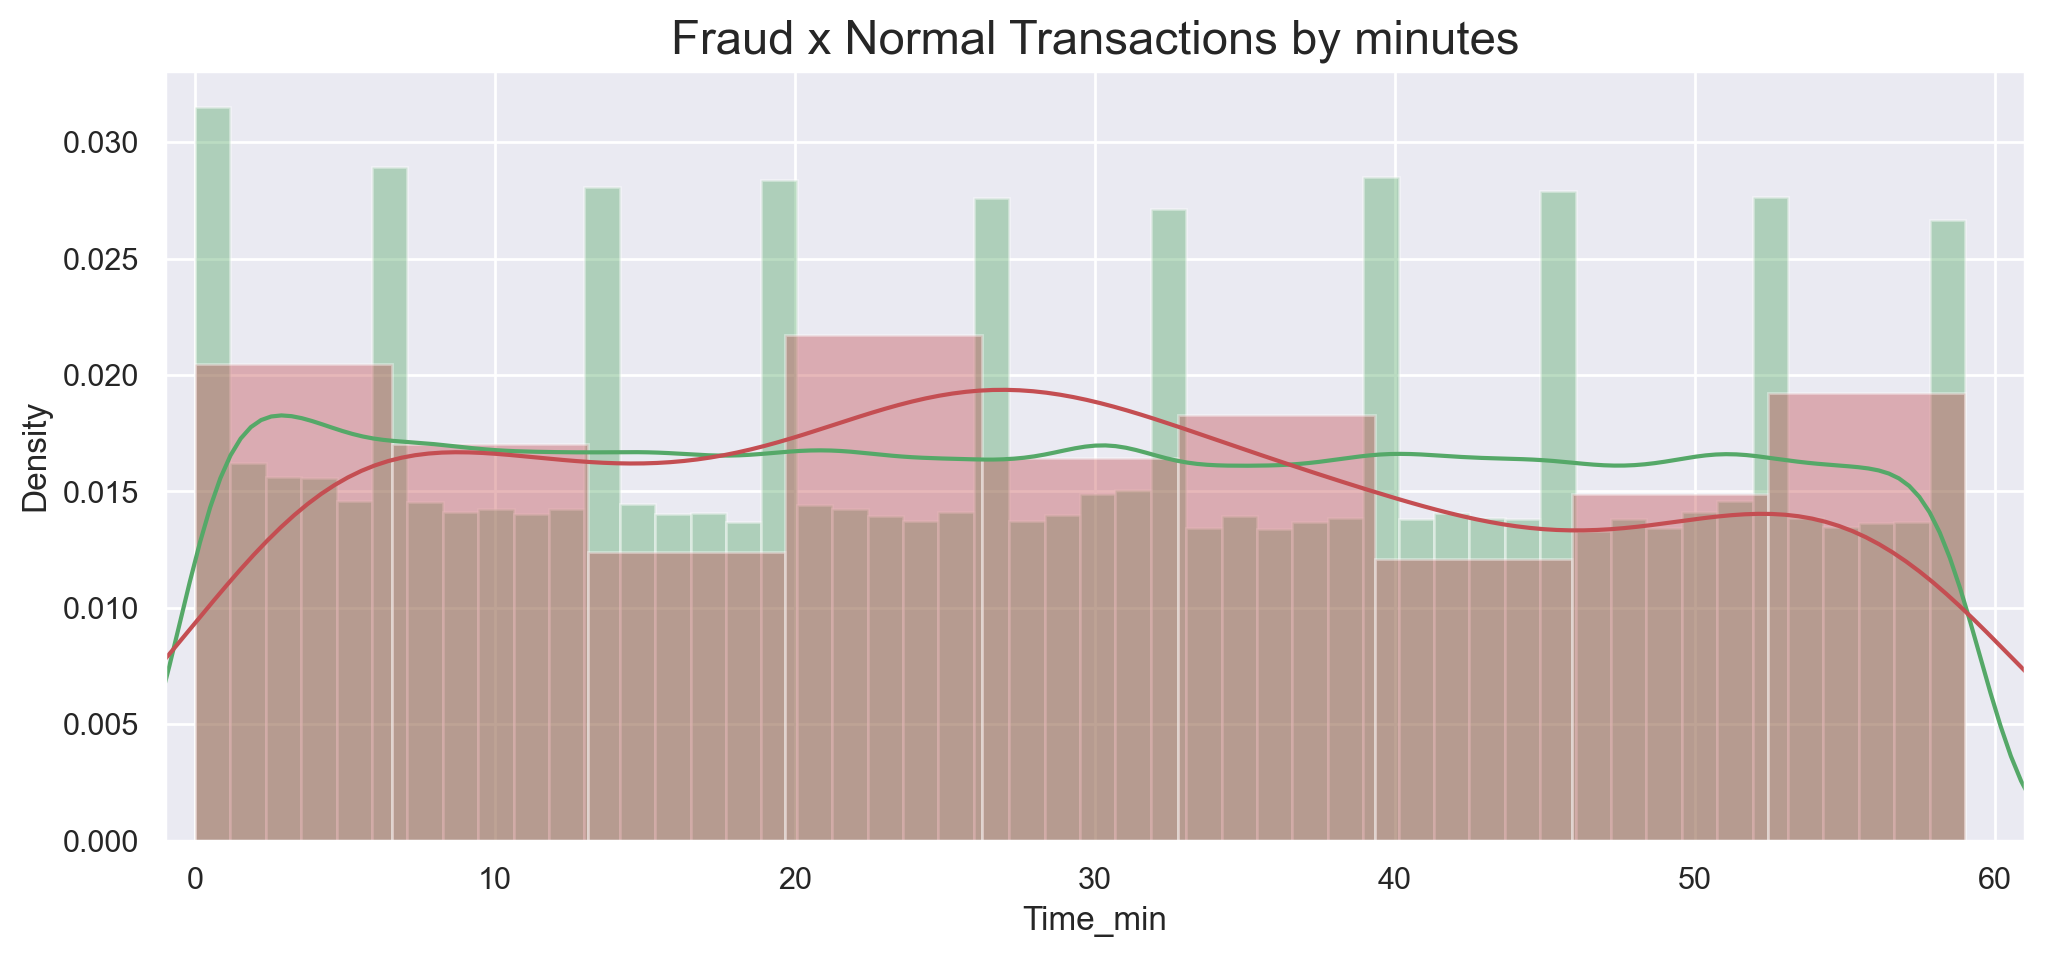

In [18]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_min"], 
             color='g')
sns.distplot(df[df['Class'] == 1]["Time_min"], 
             color='r')
plt.title('Fraud x Normal Transactions by minutes', fontsize=17)
plt.xlim([-1,61])
plt.show()

In [16]:
df_selected = df.drop(['V15','V17','V24','V27','Time_hour','Time','Time_min'], axis = 1)
df_selected.shape

(284807, 26)

In [19]:
df_training, df_testing = train_test_split(df_selected,test_size = 0.2, random_state = 42,stratify = df_selected.Class)
df_testing.Class.value_counts()

0    56864
1       98
Name: Class, dtype: int64

In [20]:
train_data,validation_data,train_lable, validation_lable = train_test_split(df_training.loc[:,df_training.columns != 'Class'],df_training.Class,test_size = 0.2, stratify  = df_training.Class,
                                                random_state = 42) 

In [21]:
##### here we are going to use min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_data)
train_data_normalised = data_scaled.transform(train_data)
validation_data_normalised = data_scaled.transform(validation_data)

In [22]:
test_data = df_testing.loc[:, df_testing.columns != 'Class']
test_lable = df_testing.Class
test_data_normalised = data_scaled.transform(test_data)

In [23]:
test_data.shape

(56962, 25)

In [24]:
train_data_normalised.shape

(182276, 25)

In [25]:
train_lable,validation_lable, test_lable = train_lable.astype(bool), validation_lable.astype(bool), test_lable.astype(bool)

In [26]:
normal_train_data = train_data_normalised[~train_lable] # normal transactions out of train_data_normalised 
normal_test_data = test_data_normalised[~test_lable] # normal transactions out of test_data_normalised
normal_validation_data = validation_data_normalised[~validation_lable]

In [27]:
print(len(normal_train_data))
print(len(normal_test_data))
print(len(normal_validation_data))

181961
56864
45490


In [28]:
fraud_train_data = train_data_normalised[train_lable]
fraud_test_data = test_data_normalised[test_lable]
fraud_validation_data = validation_data_normalised[validation_lable]

In [29]:
print(len(fraud_train_data))
print(len(fraud_test_data))
print(len(fraud_validation_data))

315
98
79


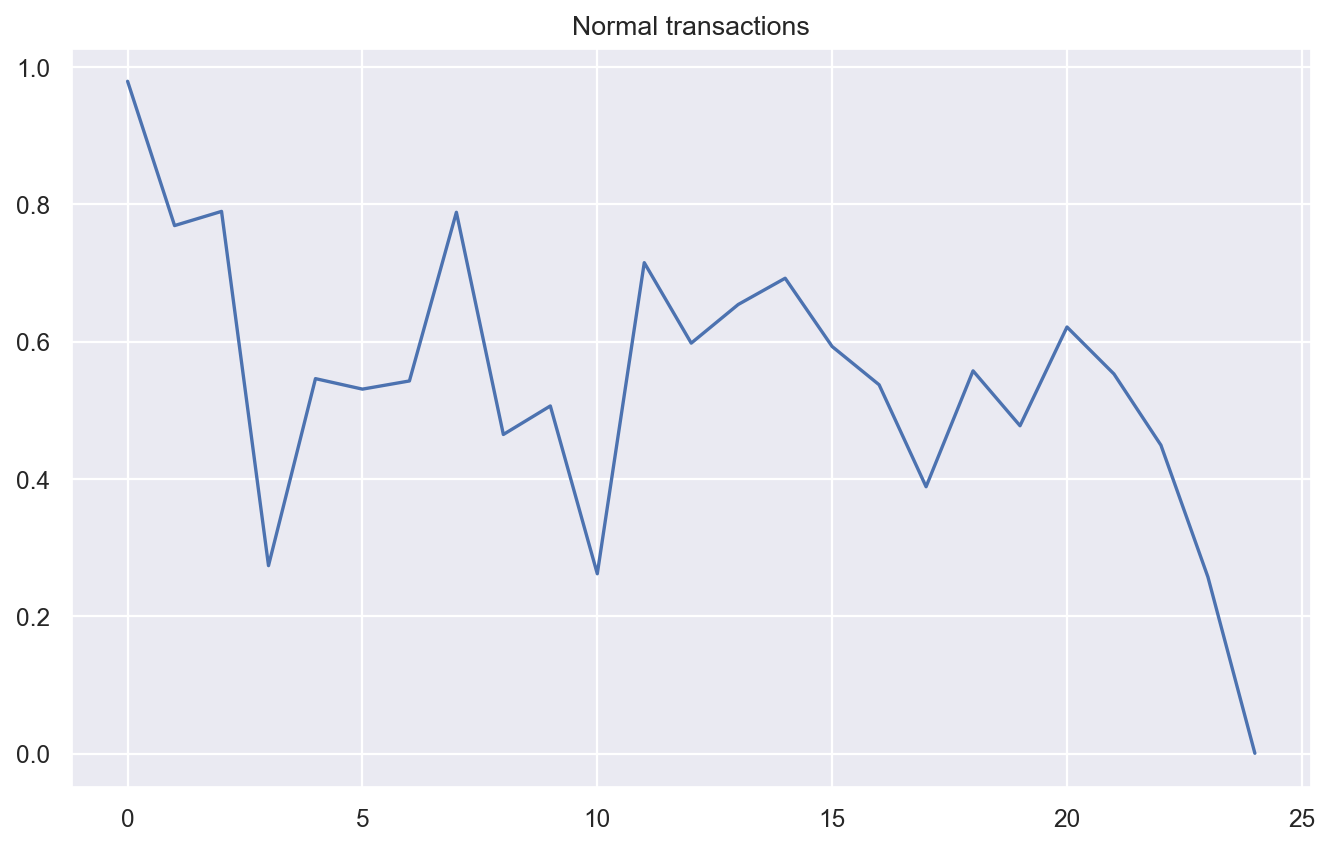

In [30]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(25), normal_train_data[1])
plt.title('Normal transactions')

plt.show()

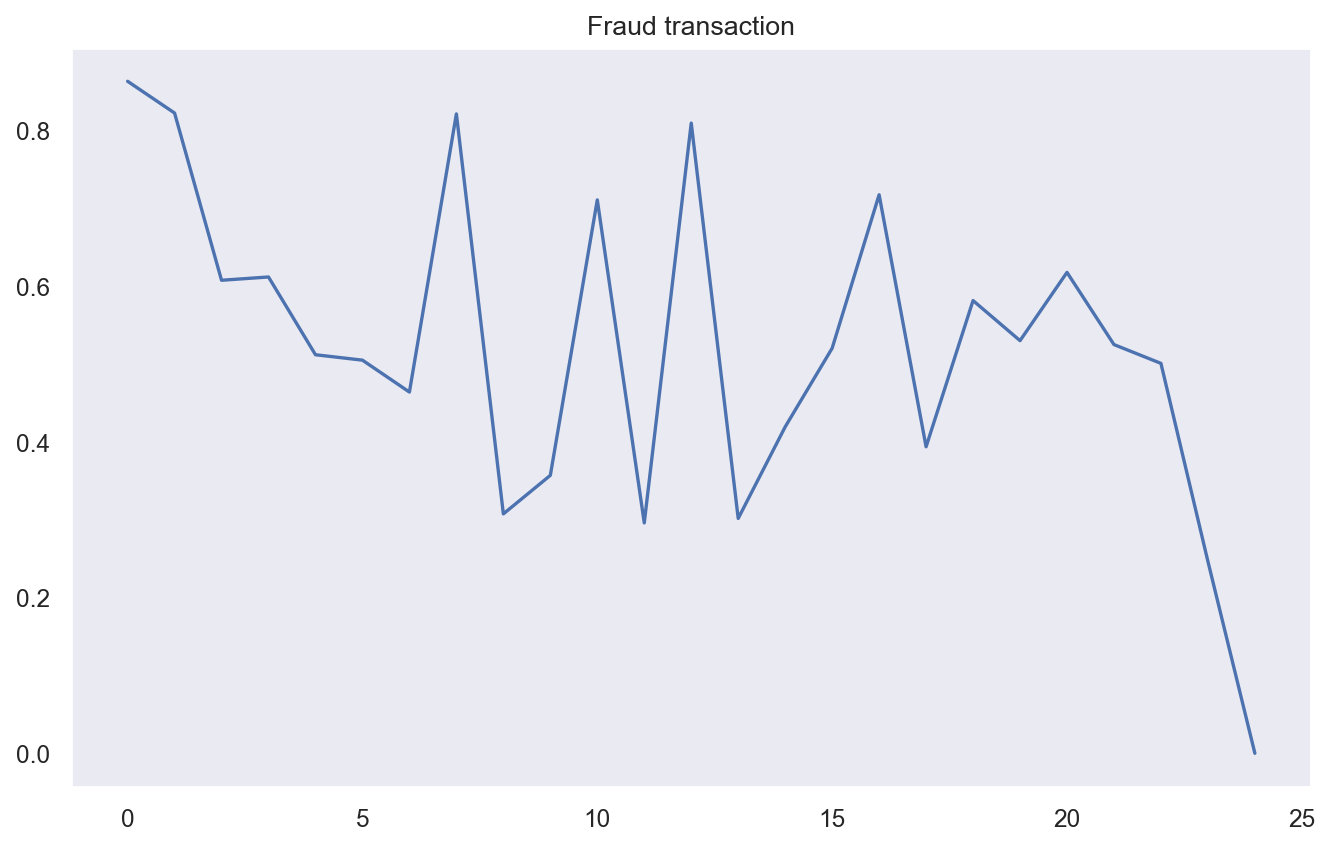

In [31]:
#Lets plot one from fraud transaction
figure(figsize=(10, 6), dpi=80)

plt.plot(np.arange(25), fraud_train_data[2])
plt.grid()
plt.title('Fraud transaction')
plt.show()

In [33]:
n_features = len(train_data.columns)
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=100, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=200, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MSE,optimizer=optimizers.Adam(),metrics=[metrics.mean_squared_error])

Epoch 1/100
5687/5687 [==============================] - 16s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.8755e-04 - val_mean_squared_error: 6.8755e-04
Epoch 2/100
5687/5687 [==============================] - 13s 2ms/step - loss: 6.9035e-04 - mean_squared_error: 6.9035e-04 - val_loss: 6.1183e-04 - val_mean_squared_error: 6.1183e-04
Epoch 3/100
5687/5687 [==============================] - 14s 2ms/step - loss: 6.3341e-04 - mean_squared_error: 6.3341e-04 - val_loss: 5.6707e-04 - val_mean_squared_error: 5.6707e-04
Epoch 4/100
5687/5687 [==============================] - 14s 2ms/step - loss: 6.0129e-04 - mean_squared_error: 6.0129e-04 - val_loss: 5.4957e-04 - val_mean_squared_error: 5.4957e-04
Epoch 5/100
5687/5687 [==============================] - 15s 3ms/step - loss: 5.6969e-04 - mean_squared_error: 5.6969e-04 - val_loss: 4.9473e-04 - val_mean_squared_error: 4.9473e-04
Epoch 6/100
5687/5687 [==============================] - 15s 3ms/step - loss: 5.2109e-04 - mean_sq

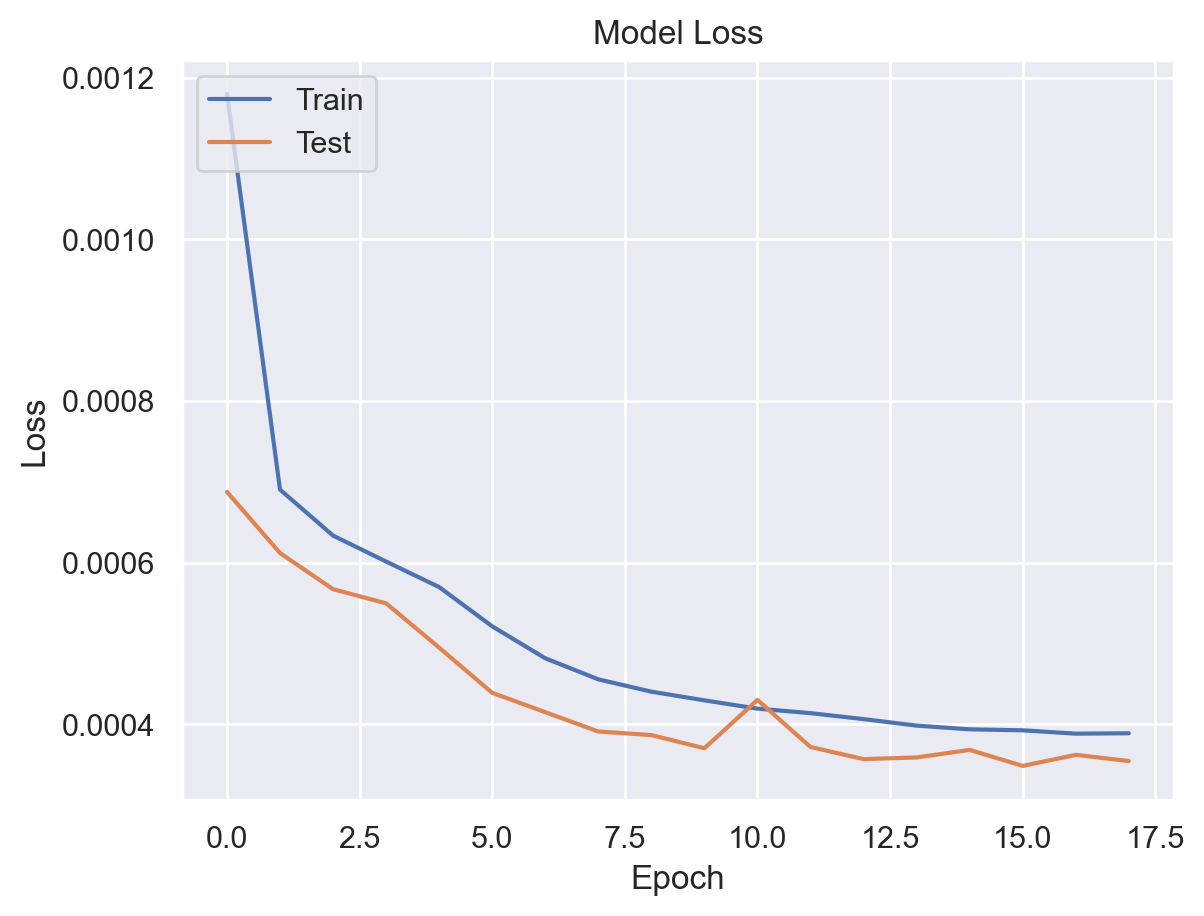

In [34]:
# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,restore_best_weights=True)
history = autoencoder.fit(x=normal_train_data, y=normal_train_data, epochs=100, verbose=1, validation_data=(normal_validation_data, normal_validation_data), callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1777/1777 [==============================] - 2s 1ms/step


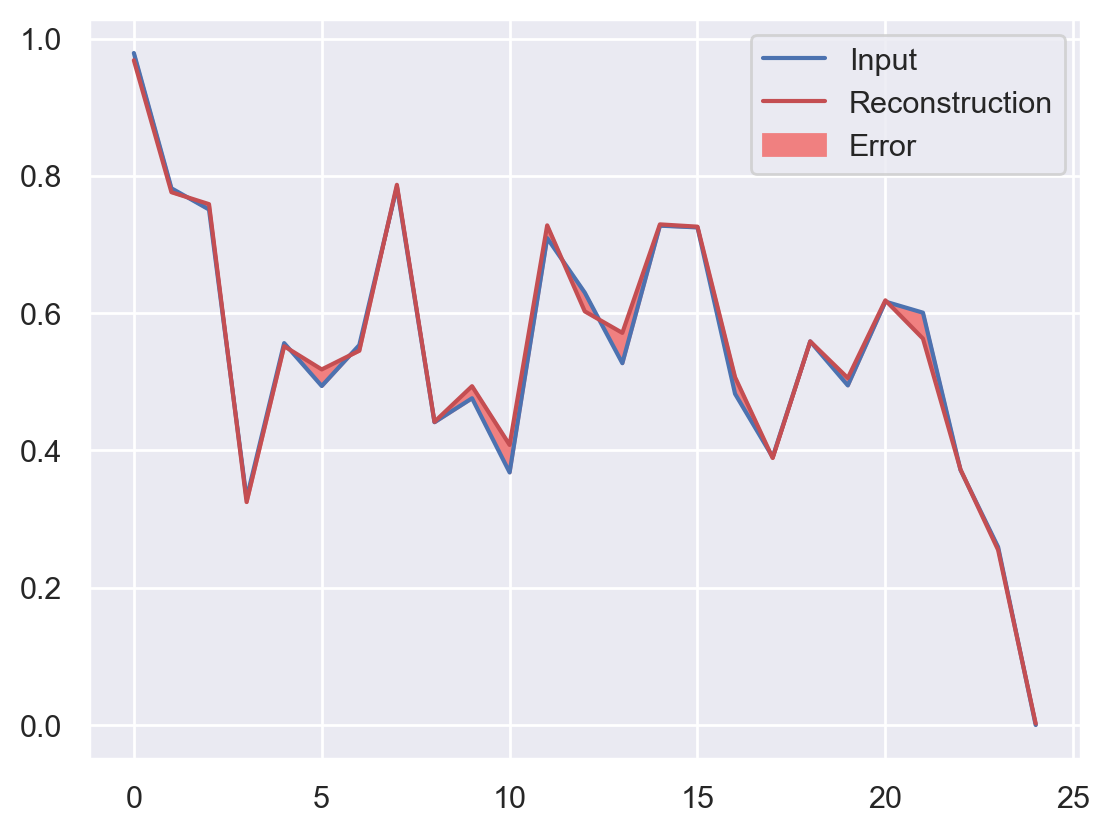

4/4 [==============================] - 0s 2ms/step


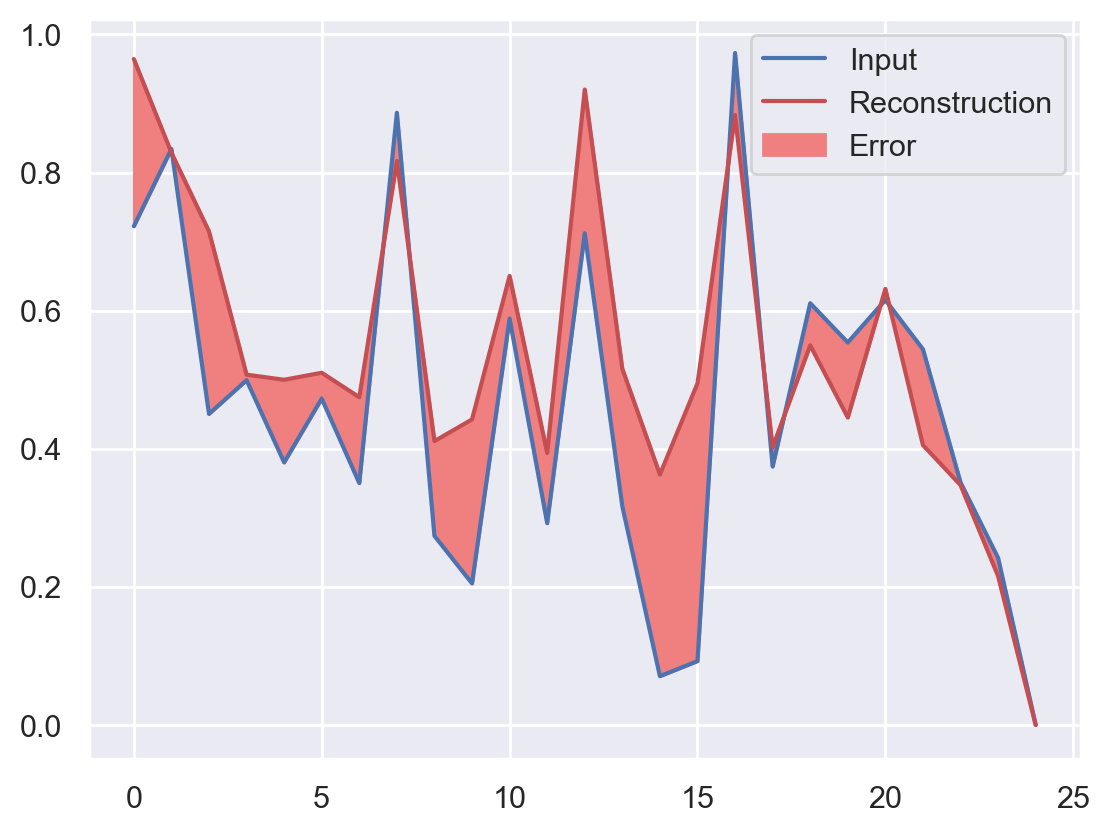

In [35]:
def plot(data, n):
    dec_img = autoencoder.predict(data) # this will decode or reconstruct
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(25), data[n], dec_img[n], color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

plot(normal_test_data, 4) # here n shows the index of ecg samples
plot(fraud_test_data, 4)


In [36]:
### calculating the train error  in legit transactions
reconstructed = autoencoder.predict(normal_train_data)
train_normal_loss = losses.mae(reconstructed, normal_train_data).numpy()
np.mean(train_normal_loss)

5687/5687 [==============================] - 6s 1ms/step


0.011879682950134831

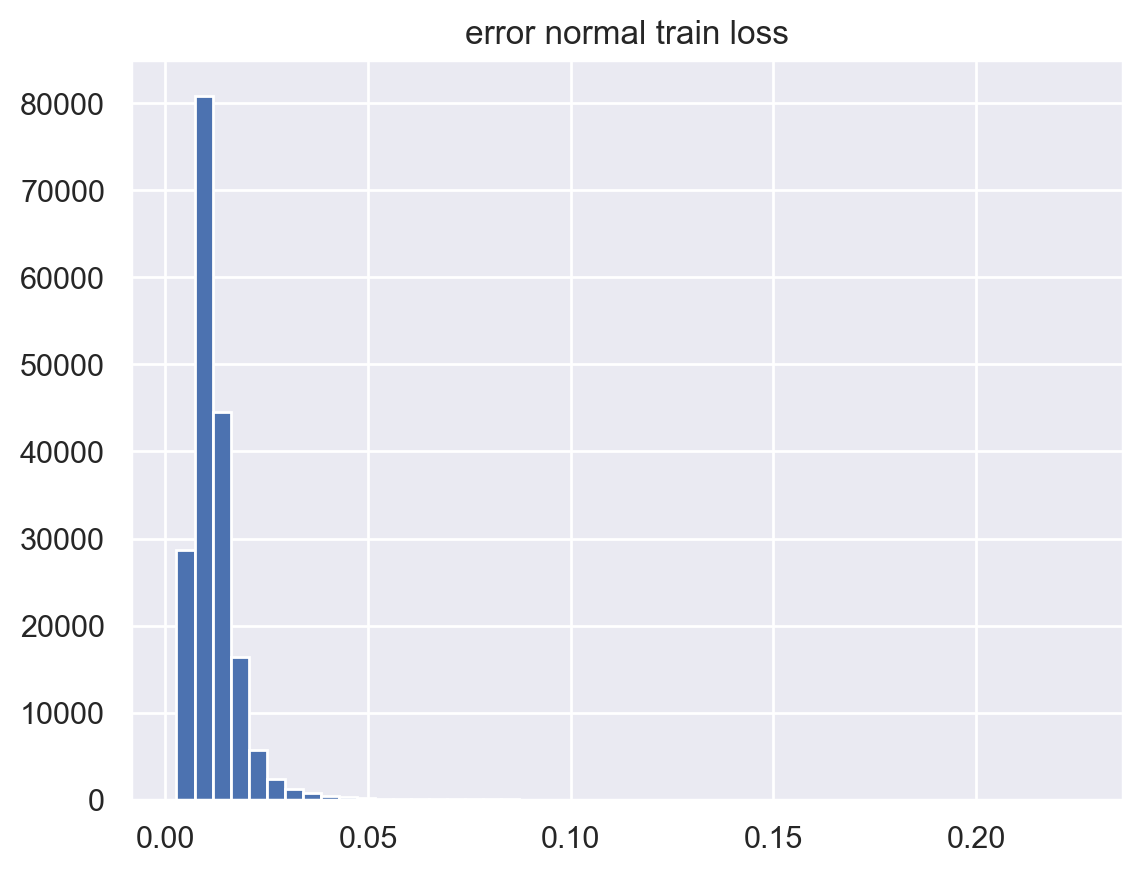

In [37]:
plt.hist(train_normal_loss, bins = 50)
plt.title('error normal train loss')
plt.show()

10/10 [==============================] - 0s 2ms/step
0.06147150733033118


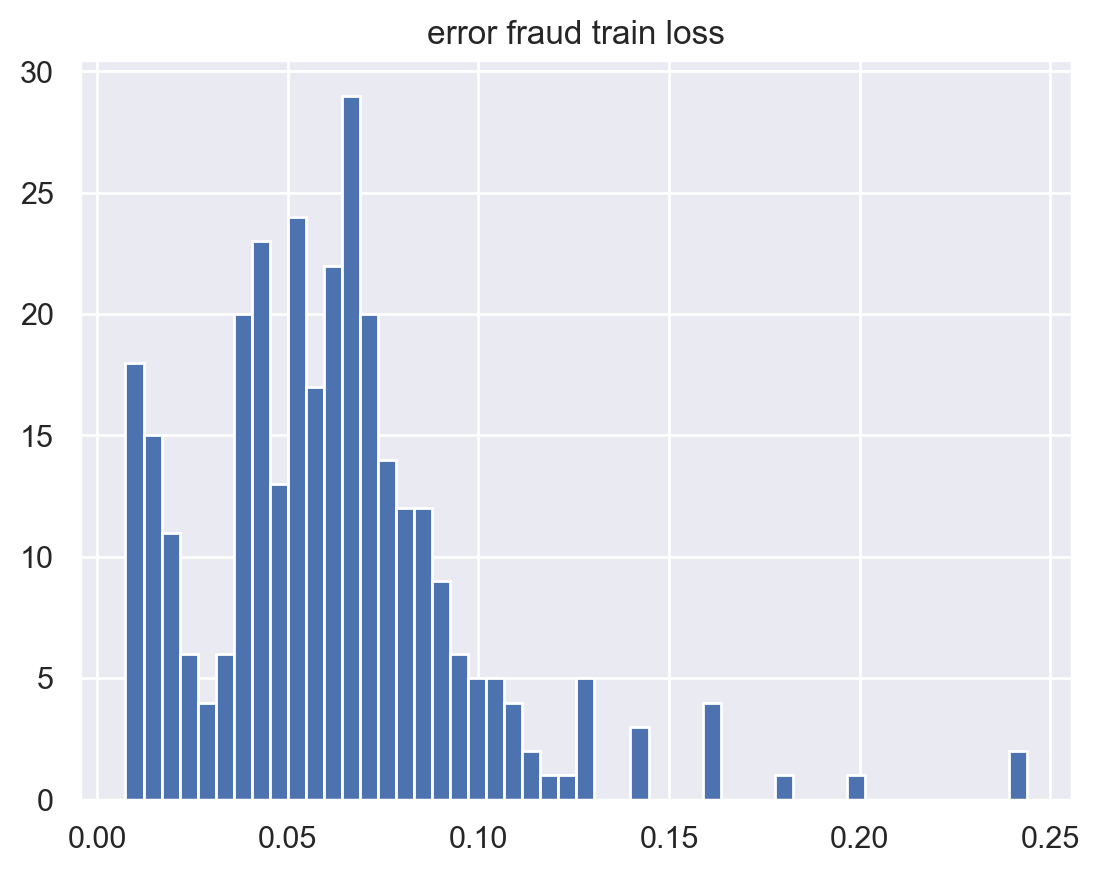

In [38]:
reconstructed = autoencoder.predict(fraud_train_data)
train_fraud_loss = losses.mae(reconstructed, fraud_train_data).numpy()
print(np.mean(train_fraud_loss))
plt.hist(train_fraud_loss, bins = 50)
plt.title('error fraud train loss')
plt.show()

In [39]:
Fraud = df.Class.sum()
total = len(df)
fraud_percentage = (Fraud/total)*100
fraud_percentage

0.1727485630620034

In [40]:
reconstructed = autoencoder.predict(train_data_normalised)
train_loss = losses.mae(reconstructed, train_data_normalised).numpy()

5697/5697 [==============================] - 6s 970us/step


In [41]:
cut_off_1 = np.percentile(train_loss, 99)
cut_off_1

0.0369315836473819

In [42]:
cut_off_2 = np.mean(train_loss) + 5*np.std(train_loss)
cut_off_2

0.04536345819536981

In [43]:
reconstructed = autoencoder.predict(test_data_normalised)
errors = losses.mae(reconstructed,test_data_normalised)
len(errors)
predicted = []
for error in errors:
    if error > cut_off_1:
        predicted.append(1)
    else:
        predicted.append(0)

1781/1781 [==============================] - 2s 996us/step


In [44]:
np.sort(errors)[::-1]

array([0.16700949, 0.16209094, 0.16209094, ..., 0.00280379, 0.0027756 ,
       0.00277319])

In [45]:
predicted_fraud_cases = np.array(predicted).sum()
actual_fraud_cases = test_lable.sum()
print('predicted_fruad_cases =>'.format(), predicted_fraud_cases, 'true fraud cases =>'.format(), actual_fraud_cases)

predicted_fruad_cases => 594 true fraud cases => 98


In [46]:
true_lable = test_lable.map({True:1,False:0})

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_lable, predicted))
print(confusion_matrix(true_lable, predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.83      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.91      0.61     56962
weighted avg       1.00      0.99      0.99     56962

[[56351   513]
 [   17    81]]


4/4 [==============================] - 0s 1ms/step


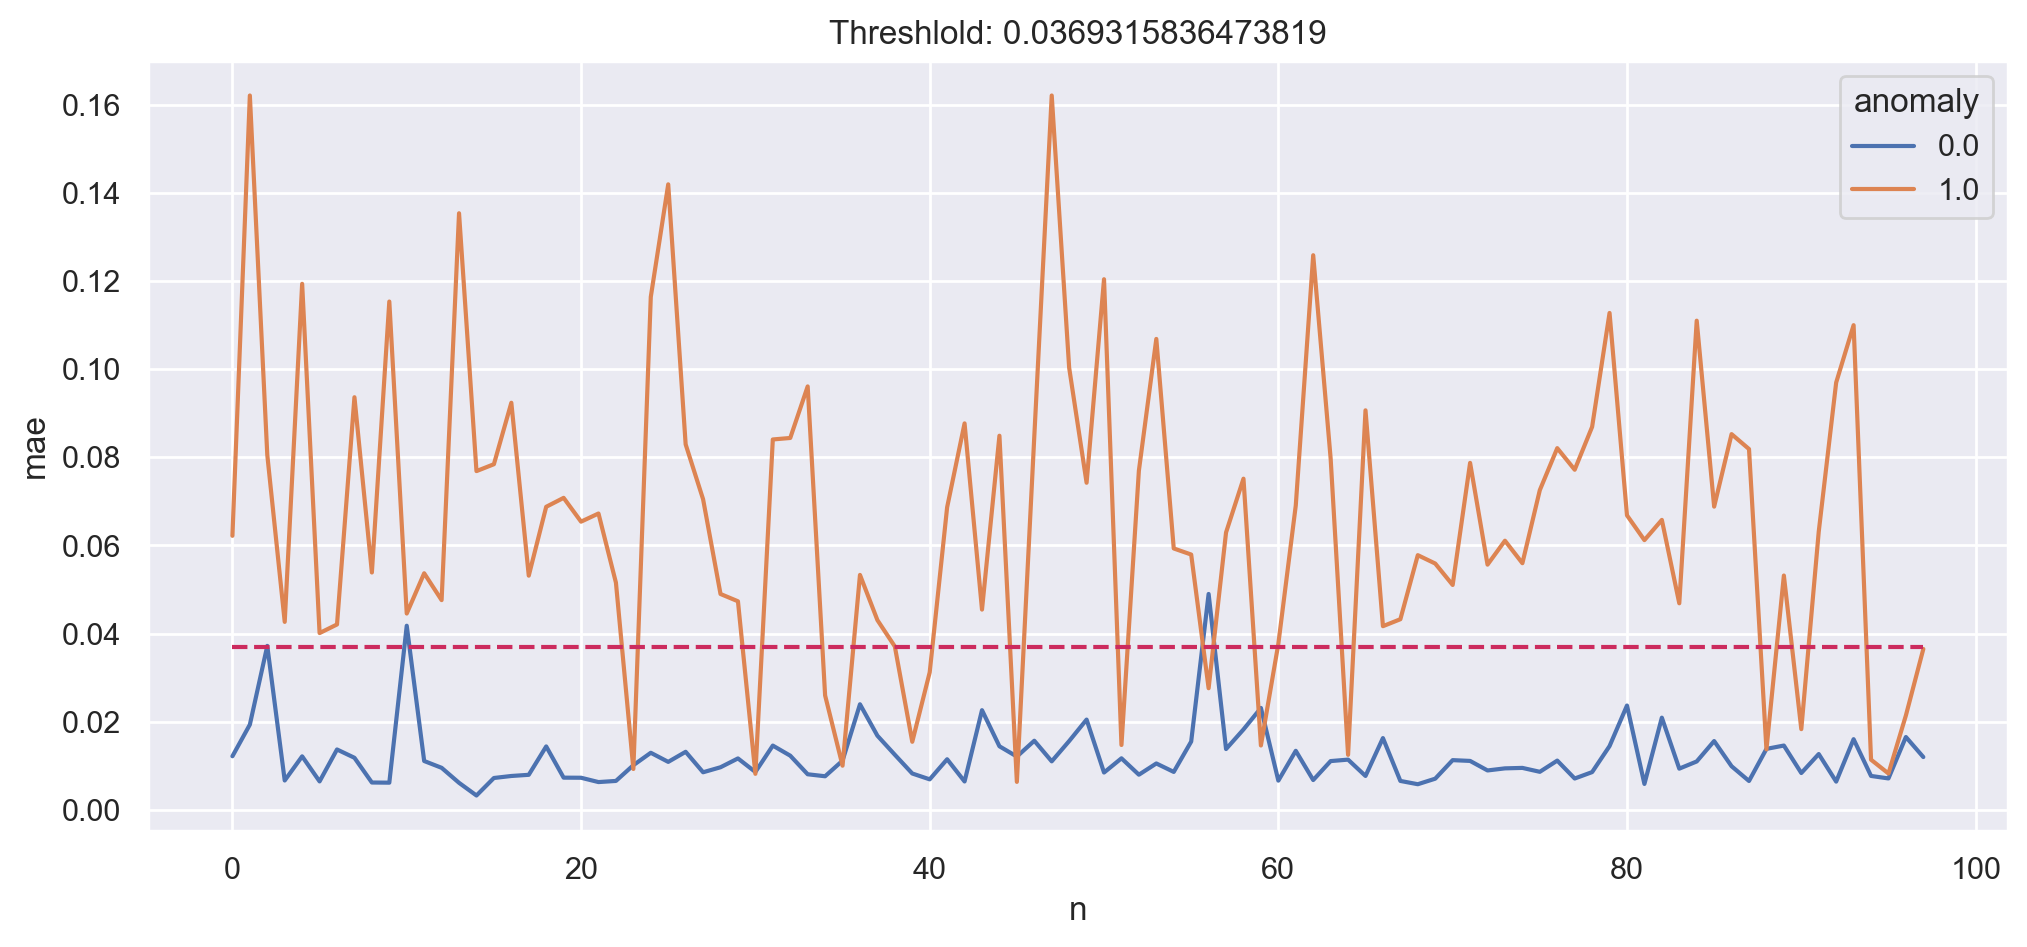

In [48]:
from matplotlib import lines
plot_samples = 98
plt.figure(figsize=(12,5))

# normal event
n_features = 25
real_x = normal_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=real_x)
normal_events_mae = losses.mae(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mae': normal_events_mae,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})


# abnormal event
abnormal_x = fraud_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mae = losses.mae(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mae': abnormal_events_mae,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})
abnormal_events_df

mae_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mae_df.n, y=mae_df.mae, hue=mae_df.anomaly)

line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off_1),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off_1))
plt.show()


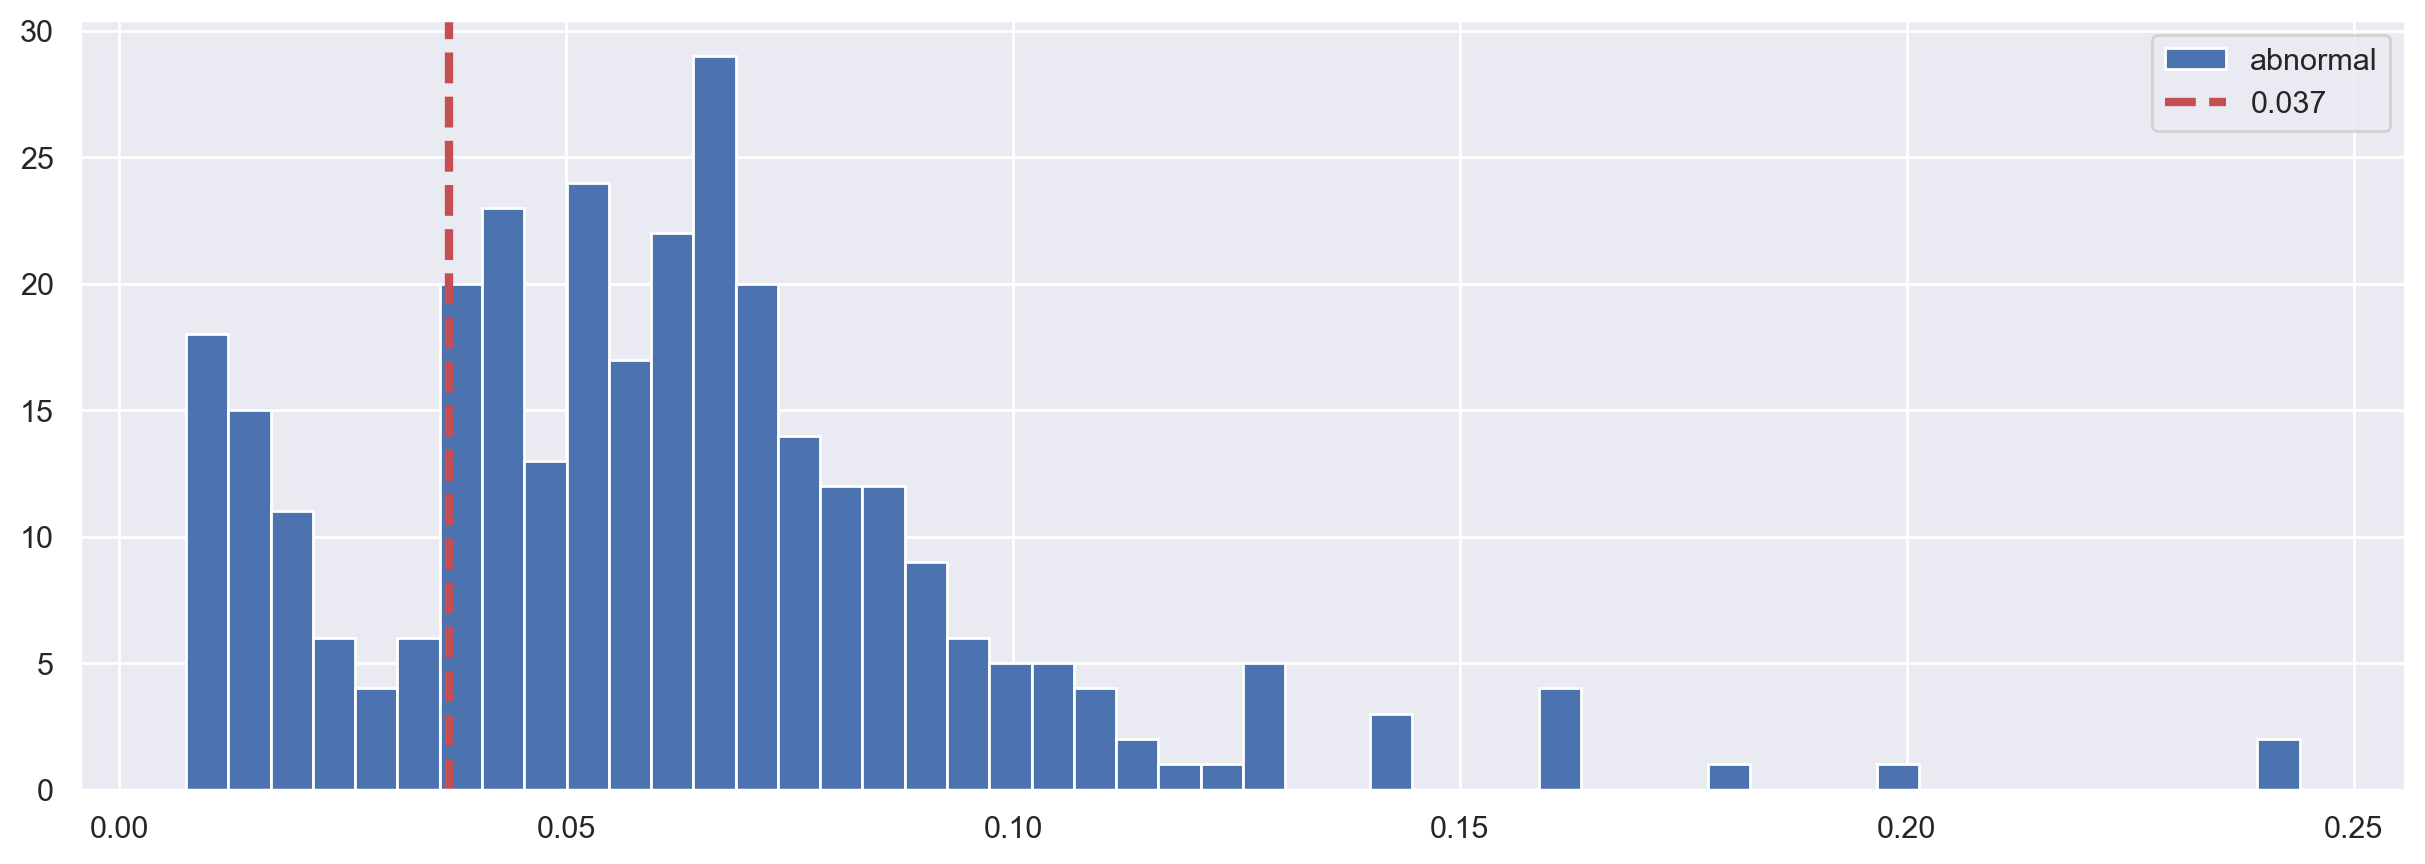

In [49]:
plt.figure(figsize=(15,5))

# plt.hist(train_normal_loss, bins = 50, label = 'normal')
plt.hist(train_fraud_loss, bins = 50, label = 'abnormal')
plt.axvline(cut_off_1, color = 'r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(cut_off_1))
plt.legend(loc = 'upper right')
plt.show()

In [50]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_min,Time_hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0
